In [1]:
import pandas as pd
from uta import solve_lp_problem, plot_utility_functions, create_full_ranking_df, check_consistency, obtain_relations

In [2]:
df = pd.read_csv('Nuclear waste management.csv', index_col=0)

In [3]:
preferential_information = [(5, 1), (11, 24), (14, 27)]
indifference_information = [(3, 7), (22, 23)]

In [4]:
problem, u_vars, criteria, breakpoints = solve_lp_problem(df, preferential_information, indifference_information, verbose=False)

Kryteria: ['C1', 'C2', 'C3', 'C4']
Stworzono zmienną decyzyjną: epsilon o dolnym ograniczeniu 0
Dodano funkcję celu: epsilon
Dodano ograniczenia wynikające z rankingu referencyjnego
Dodano ograniczenia wynikające z normalizacji i nieujemnosci
Dodano ograniczenia wynikające z monotoniczności
Ostateczny problem do rozwiązania:
Status: Optimal


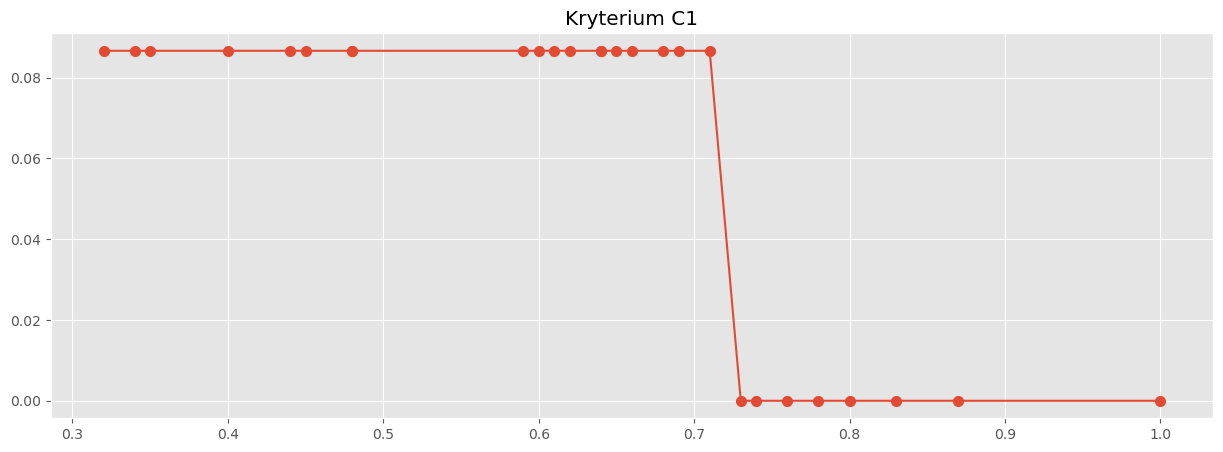

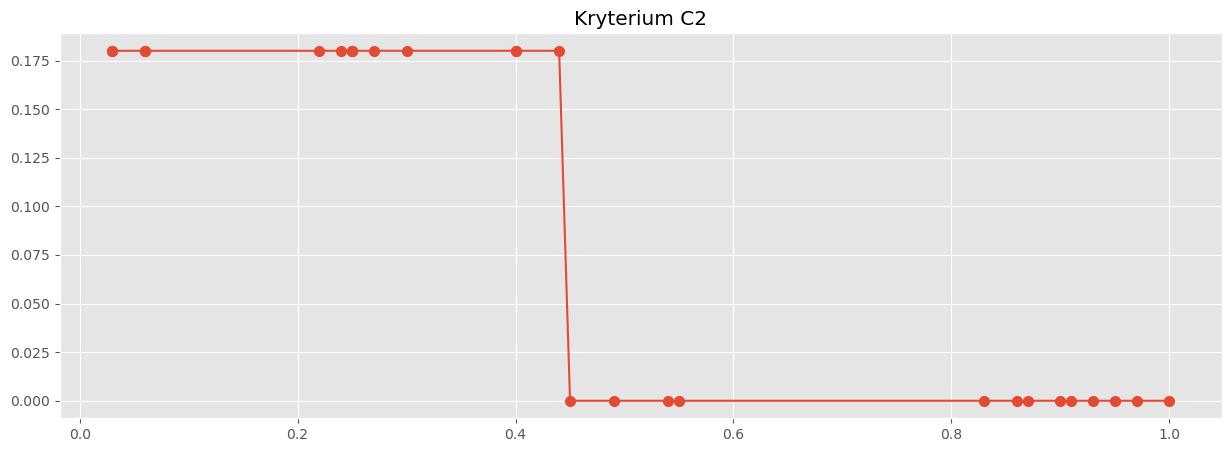

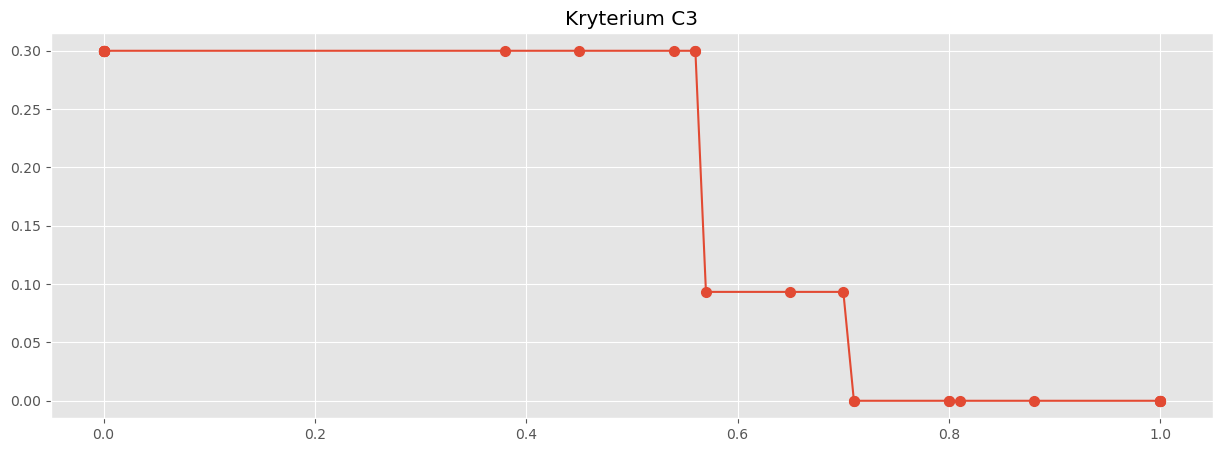

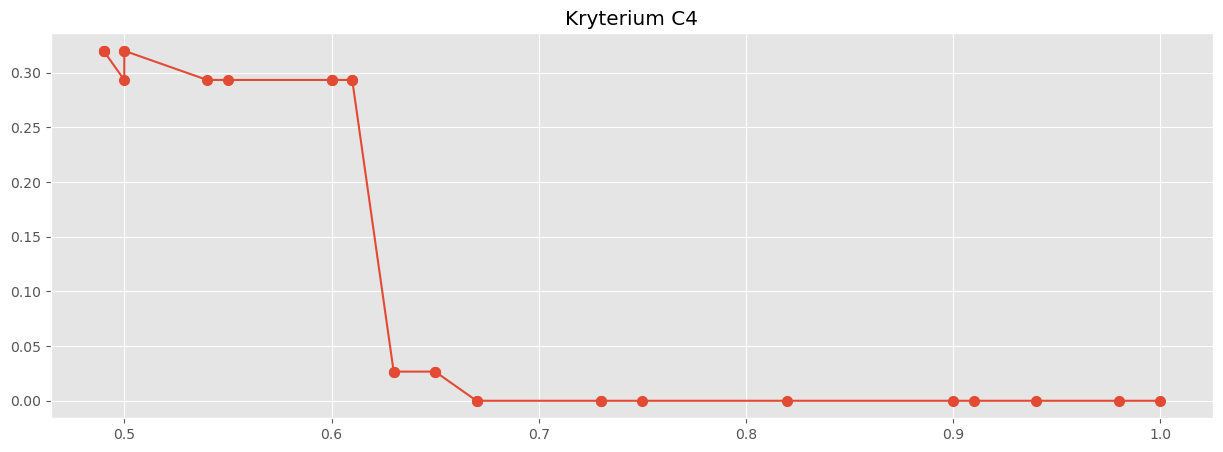

In [5]:
plot_utility_functions(problem, u_vars, criteria, breakpoints)

Brzydki ostatni wykres - inne wartosci f.uzytecznosci czastk. dla wariantow majacych taka sama wartosc na danym kryterium - dziwne, ale na slajdach w ten sposob jest problem formułowany (nierówność nieostra):

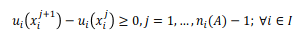

In [6]:
rank = create_full_ranking_df(df, problem, criteria)

In [7]:
check_consistency(rank, preferential_information, indifference_information)

True

In [ ]:
rank.sort_values(by='U', ascending=False)

In [10]:
necessarily_preferred, possibly_preffered = obtain_relations(rank)

In [58]:
subset_size = 2
subset_dict = {k: v for k, v in necessarily_preferred.items() if len(v) > 0}  # Only include non-empty lists
subset_dict = dict(list(necessarily_preferred.items())[:subset_size])

print(subset_dict)

{1: [4, 7, 10, 13, 16, 19, 22, 25], 2: [1, 3, 4, 7, 10, 11, 13, 14, 16, 19, 22, 25]}


Text(0.5, 1.0, 'Preferential Relations Tree')

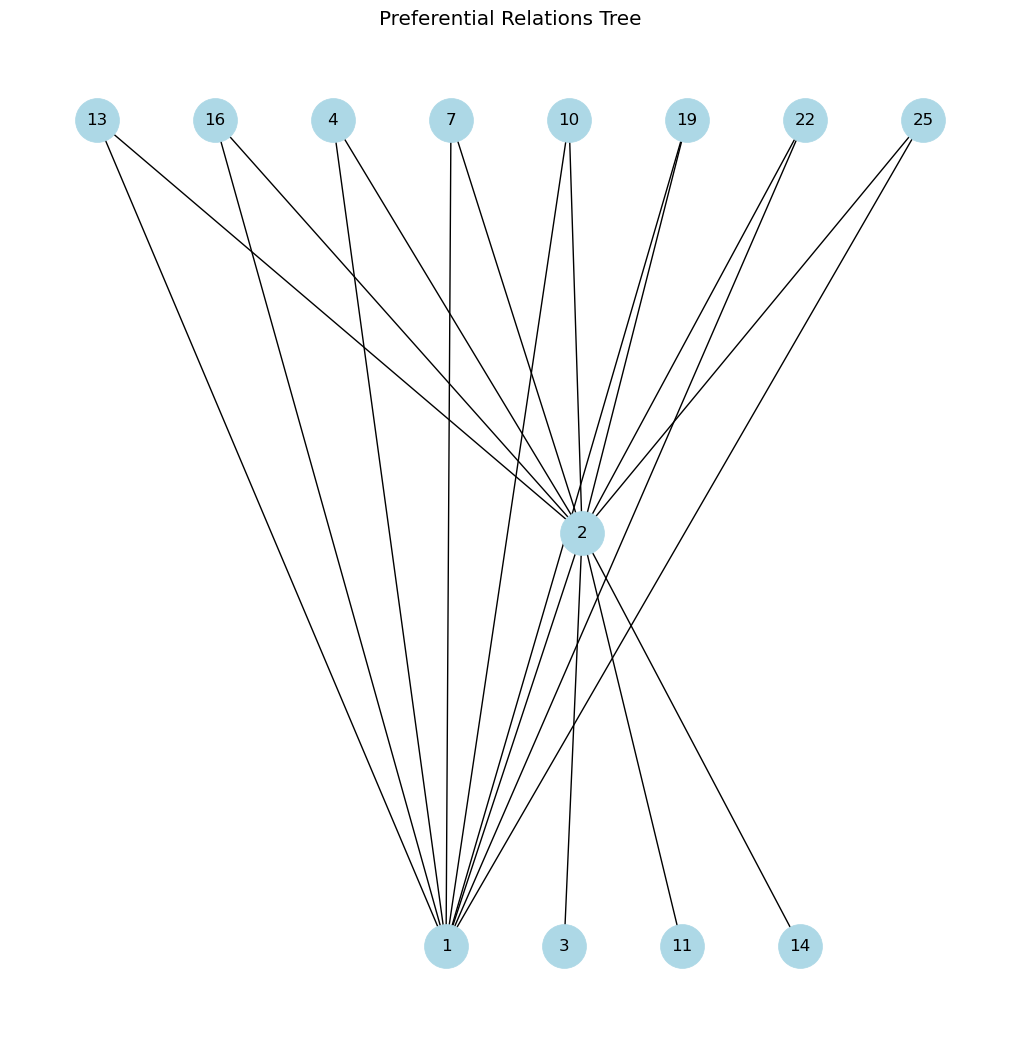

In [59]:
import networkx as nx
import matplotlib.pyplot as plt

# data = necessarily_preferred.copy()
data = subset_dict.copy()
G = nx.DiGraph()

for parent, children in data.items():
    for child in children:
        for key, value in data.items():
            if key != parent and child in value:
                G.add_edge(child, parent)
                break
        else:
            G.add_edge(parent, child)

nx.nx_agraph.write_dot(G,'test.dot')
pos=graphviz_layout(G, prog='dot')
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, arrows=False, node_size=1000, node_color='lightblue', font_size=12)
plt.title('Preferential Relations Tree')

In [ ]:
data = necessarily_preferred.copy()

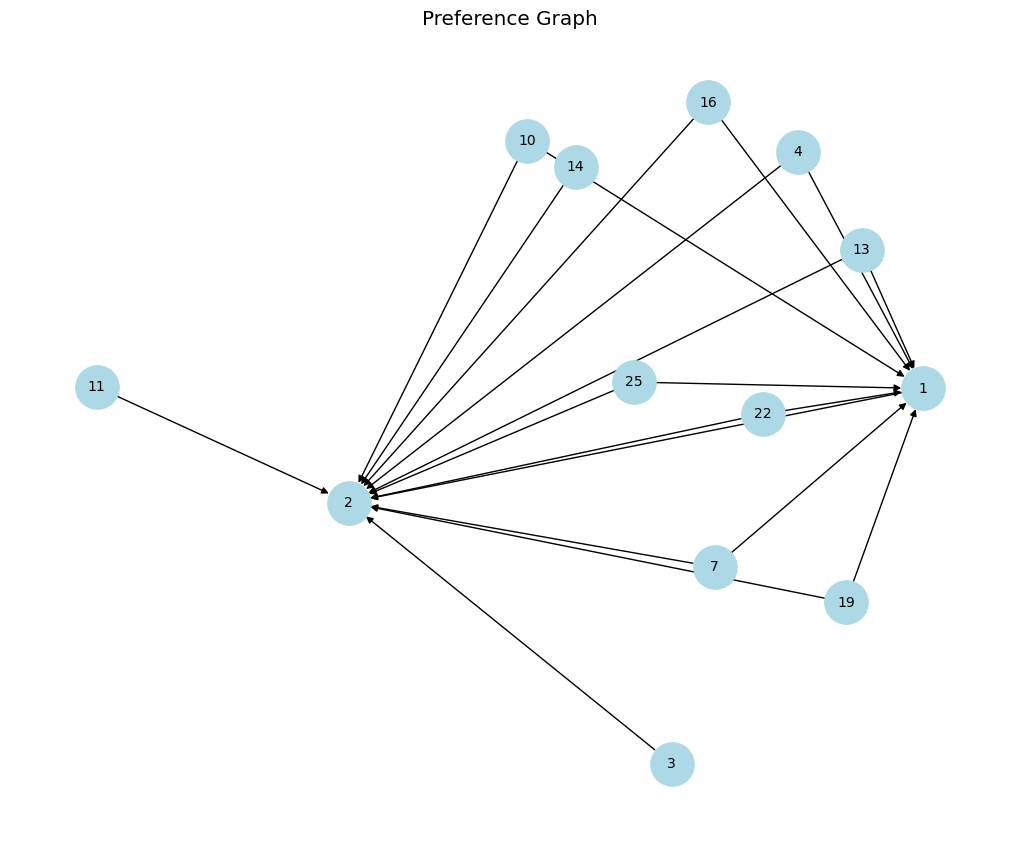

In [65]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for node, edges in data.items():
    for edge in edges:
        G.add_edge(edge, node)  # Reversed direction

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, pos=nx.spring_layout(G, seed=42), arrows=True)
plt.title('Preference Graph')
plt.show()
